<a href="https://colab.research.google.com/github/kick0909/classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
!wget https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
!unzip master.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/147_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/148_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/149_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/150_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/151_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/152_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/153_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/154_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/155_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/156_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/157_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/158_100.jpg  
  inflating: Fruit-Images-Dataset-master/Training/Tomato 3/159_100.jpg  


In [3]:
num_classes = 131

learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32
conv2_filters = 64
fc1_units = 1024

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/Fruit-Images-Dataset-master/Training"
test_dir = "/content/Fruit-Images-Dataset-master/Test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(100, 100), batch_size=32, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(100, 100), batch_size=32, class_mode='categorical'
)


class_labels = list(train_generator.class_indices.keys())

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [6]:
random_normal = tf.initializers.RandomNormal()

fc_input_dim = (100 // 4) * (100 // 4) * conv2_filters

weights = {
    'wc1': tf.Variable(random_normal([5, 5, 3, conv1_filters])),
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    'wd1': tf.Variable(random_normal([fc_input_dim, fc1_units])),
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}


In [7]:
def conv_net(x):

    # Convolution Layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Flatten for Fully Connected Layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].shape[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # Output layer
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return tf.nn.softmax(out)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def cross_entropy(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)  # Avoid log(0)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))  # Ensure correct reduction

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

optimizer = tf.optimizers.Adam(learning_rate)

In [9]:
# Optimization process.
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
for batch_x, batch_y in train_generator:
    print("Batch X shape:", batch_x.shape)
    print("Batch Y shape:", batch_y.shape)
    break

Batch X shape: (32, 100, 100, 3)
Batch Y shape: (32, 131)


In [24]:
# Run training for the given number of steps.
for step in range(training_steps):
    batch_x, batch_y = next(train_generator)  # Fetch batch from ImageDataGenerator

    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Step: {step}, Loss: {loss:.6f}, Accuracy: {acc:.6f}")


Step: 0, Loss: 0.131731, Accuracy: 0.968750
Step: 10, Loss: 0.085714, Accuracy: 0.968750
Step: 20, Loss: 0.208637, Accuracy: 0.968750
Step: 30, Loss: 0.122661, Accuracy: 0.937500
Step: 40, Loss: 0.064853, Accuracy: 1.000000
Step: 50, Loss: 0.163148, Accuracy: 0.968750
Step: 60, Loss: 0.115635, Accuracy: 1.000000
Step: 70, Loss: 0.163293, Accuracy: 0.937500
Step: 80, Loss: 0.141358, Accuracy: 0.968750
Step: 90, Loss: 0.101306, Accuracy: 0.968750
Step: 100, Loss: 0.114686, Accuracy: 0.968750
Step: 110, Loss: 0.066384, Accuracy: 1.000000
Step: 120, Loss: 0.112390, Accuracy: 0.968750
Step: 130, Loss: 0.059379, Accuracy: 1.000000
Step: 140, Loss: 0.047523, Accuracy: 1.000000
Step: 150, Loss: 0.042329, Accuracy: 1.000000
Step: 160, Loss: 0.040783, Accuracy: 1.000000
Step: 170, Loss: 0.249741, Accuracy: 0.906250
Step: 180, Loss: 0.071890, Accuracy: 1.000000
Step: 190, Loss: 0.134440, Accuracy: 0.968750


In [48]:
pred = conv_net(batch_x)
print("Train Accuracy: %f" % accuracy(pred, batch_y))

Train Accuracy: 1.000000


In [14]:
import matplotlib.pyplot as plt

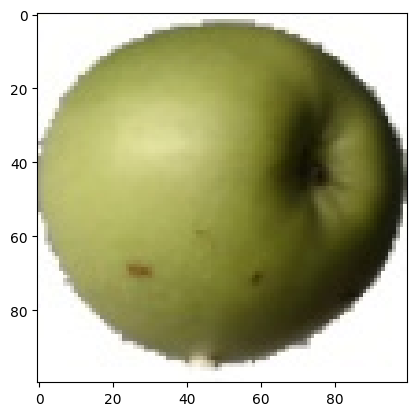

Model prediction: Apple Granny Smith


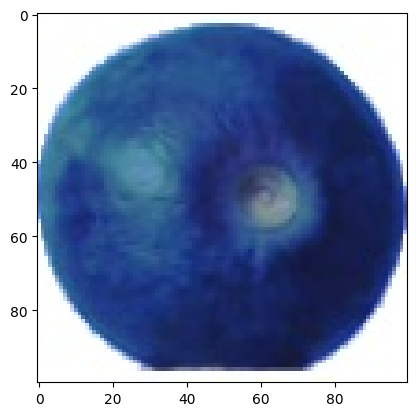

Model prediction: Huckleberry


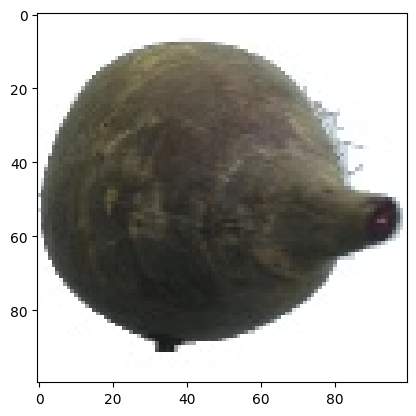

Model prediction: Beetroot


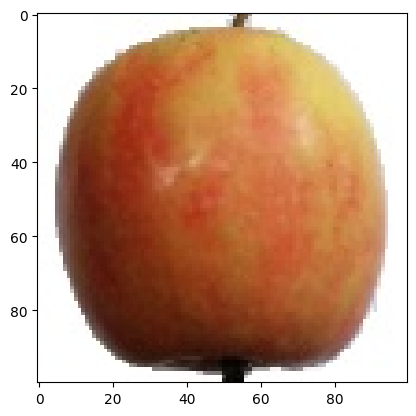

Model prediction: Apple Pink Lady


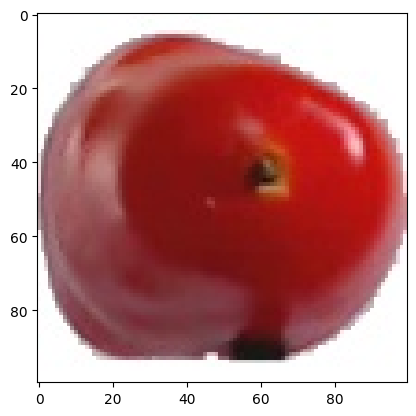

Model prediction: Tomato 2


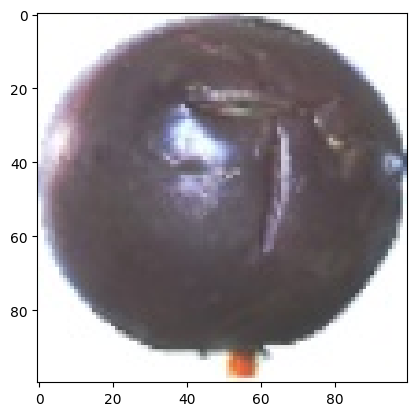

Model prediction: Passion Fruit


In [54]:
# Predict 5 images from validation set.
n_images = 6
test_images = batch_x[:n_images]
predictions = conv_net(test_images)

# Display image and predicted class name.
for i in range(n_images):
    plt.imshow(test_images[i])  # No reshaping needed
    plt.show()

    # Get predicted class index
    predicted_index = np.argmax(predictions.numpy()[i])

    # Get class name from index
    predicted_class = class_labels[predicted_index]

    print(f"Model prediction: {predicted_class}")  # Print class name


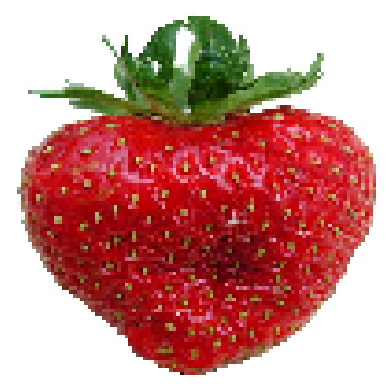

Predicted class: Tamarillo


In [53]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/Strawberry_fruit.jpg"  # Set your image path
img = image.load_img(img_path, target_size=(100, 100))  # Resize to 100x100
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Display the image
plt.imshow(img)
plt.axis("off")
plt.show()

# Make a prediction
prediction = conv_net(img_array)

# Get predicted class index
predicted_index = np.argmax(prediction.numpy())

# Get class labels from train_generator
class_labels = list(train_generator.class_indices.keys())

# Get predicted class name
predicted_class = class_labels[predicted_index]

print(f"Predicted class: {predicted_class}")
